In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [38]:
from dataclasses import replace
import json
from pathlib import Path
import pickle

import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from src.analysis.state_space import prepare_word_trajectory_spec, prepare_state_trajectory
from src.datasets.speech_equivalence import SpeechEquivalenceDataset
from src.models import get_best_checkpoint
from src.models.integrator import ContrastiveEmbeddingModel, load_or_compute_embeddings

In [6]:
# model_checkpoint = "../out/ce_model_phoneme_within_word_prefix_6_32/checkpoint-600"
# equiv_dataset_path = "../data/timit_equiv_phoneme_within_word_prefix_1.pkl"
model_dir = "outputs/models/w2v2_6_8/phoneme_within_word_prefix"
equiv_dataset_path = "data/timit_equivalence_facebook-wav2vec2-base_6-phoneme-1.pkl"

state_space_spec = "out/state_space_specs/all_words.pkl"
complex_cohort_spec = "complex_cohort_set.json"

out = "complex_cohort.gif"

In [7]:
Path(out).parent.mkdir(parents=True, exist_ok=True)

In [8]:
model = ContrastiveEmbeddingModel.from_pretrained(get_best_checkpoint(model_dir))
model.eval()

/home/jgauthier/u/transformers/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


ContrastiveEmbeddingModel(
  (rnn): RNNModel(
    (rnn): LSTM(768, 32, batch_first=True)
    (fc): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [9]:
with open(equiv_dataset_path, "rb") as f:
    equiv_dataset: SpeechEquivalenceDataset = pickle.load(f)

In [10]:
with open(state_space_spec, "rb") as f:
    state_space_spec = pickle.load(f)
assert state_space_spec.is_compatible_with(equiv_dataset)

In [11]:
with open(complex_cohort_spec, "r") as f:
    cohort_spec = json.load(f)

In [12]:
model_representations = load_or_compute_embeddings(model, equiv_dataset, model_dir, equiv_dataset_path)

In [15]:
# Subset state space based on cohort of interest
target_word, (prefix_overlaps, suffix_overlaps) = next(iter(cohort_spec.items()))
all_words = [target_word] + prefix_overlaps + suffix_overlaps

drop_idxs = [idx for idx, word in enumerate(state_space_spec.labels) if word not in all_words]
state_space_spec = state_space_spec.drop_labels(drop_idxs)
is_prefix = np.array([label in prefix_overlaps for label in state_space_spec.labels])
is_suffix = np.array([label in suffix_overlaps for label in state_space_spec.labels])

In [39]:
# Fit PCA on just the frames selected by the trajectory
pca = PCA(n_components=2)
pca_fit_data = np.concatenate([
    model_representations[start_frame:end_frame]
    for traj_i in state_space_spec.target_frame_spans
    for start_frame, end_frame in traj_i
])
pca.fit(pca_fit_data)

model_representations_pca = pca.transform(model_representations)

AttributeError: 'TSNE' object has no attribute 'transform'

In [31]:
trajectory = prepare_state_trajectory(model_representations_pca, state_space_spec)

In [32]:
len(trajectory), trajectory[0].shape

(27, (2, 52, 2))

In [33]:
min, max = np.concatenate(trajectory).min(), np.concatenate(trajectory).max()

In [34]:
is_prefix

array([False, False, False, False, False, False,  True, False, False,
       False, False,  True, False, False,  True,  True, False, False,
        True, False, False, False, False, False,  True, False, False])

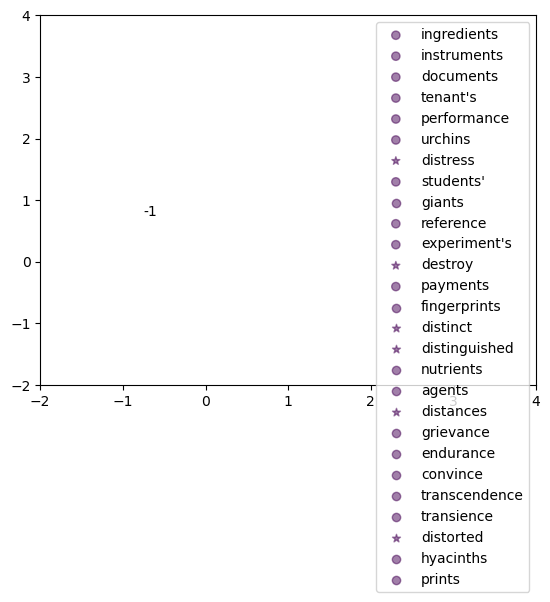

In [35]:
# Animate
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig, ax = plt.subplots()
ax.set_xlim(np.floor(min), np.ceil(max))
ax.set_ylim(np.floor(min), np.ceil(max))
annot_frame = ax.text(-0.75, 0.75, "-1")
scats = [ax.scatter(np.zeros(traj_i.shape[0]), np.zeros(traj_i.shape[0]),
                    alpha=0.5,
                    marker="*" if is_prefix[i] else "o",
                    c=np.zeros(traj_i.shape[0]),
               #  c=np.repeat(100 * int(is_prefix[i]), traj_i.shape[0]),
               # cmap="viridis"
                   ) for i, traj_i in enumerate(trajectory)]
ax.legend(scats, state_space_spec.labels, loc=1)

def init():
    for scat in scats:
        scat.set_offsets(np.zeros((0, 2)))
    return tuple(scats)

def update(frame):
    for scat, traj_i, is_prefix_i in zip(scats, trajectory, is_prefix):
        scat.set_offsets(traj_i[:, frame])
        # set color
        # scat.set_array(np.repeat(100 * int(is_prefix_i), traj_i.shape[0]))
    annot_frame.set_text(str(frame))
    return tuple(scats) + (annot_frame,)

# Animate by model frame
num_frames = trajectory[0].shape[1]
ani = animation.FuncAnimation(fig, update, frames=num_frames, interval=500,
                              init_func=init)
# ani.save("test.gif", writer="ffmpeg")

In [36]:
from IPython.display import HTML
HTML(ani.to_jshtml())